![](http://mymommyology.com/wp-content/uploads/2011/06/dora-the-explorer-logo1.jpg)

In [142]:
# special IPython command to prepare the notebook for matplotlib
%matplotlib inline 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#added this because it's indicated as useful but not imported
import urllib
from zipfile import ZipFile
from io import BytesIO
import os
import json

I Definitely copy and pasted this next piece. I found it here:
http://stackoverflow.com/a/13895723

In [2]:
def reporthook(blocknum, blocksize, totalsize):
    readsofar = blocknum * blocksize
    if totalsize > 0:
        percent = readsofar * 1e2 / totalsize
        s = "\r%5.1f%% %*d / %d" % (
            percent, len(str(totalsize)), readsofar, totalsize)
        os.sys.stderr.write(s)
        if readsofar >= totalsize: # near the end
            os.sys.stderr.write("\n")
    else: # total size is unknown
        os.sys.stderr.write("read %d\n" % (readsofar,))

In [3]:
datadir = "data"
try:
    os.makedirs(datadir)
except:
    pass #directory already exists. :P

## Q1: Is gentrification the cause of rent hikes in Crown Heights, Brooklyn?

In [4]:
#how do we answer this?

## Q2: Are new people moving in below the median income?

In [13]:
some_zip_files = ["https://www.huduser.gov/portal/datasets/fmr/fmr2016p/asq_zctadata_2013_00000to19999.zip",
                 "https://www.huduser.gov/portal/datasets/fmr/fmr2017/FY2017_hypothetical_safmrs.xlsx"]

In [14]:
#my attempt at data caching
for some_zip_file in some_zip_files:
    try:
        zipF = ZipFile(os.path.join(datadir,some_zip_file.split("/")[-1]))
    except FileNotFoundError as e:
        #if zip doesn't exist, download it and try opening it again
        urllib.request.urlretrieve(some_zip_file, os.path.join(datadir,some_zip_file.split("/")[-1]), reporthook)
        zipF = ZipFile(os.path.join(datadir,some_zip_file.split("/")[-1]))
    print(zipF.namelist())

['asq_zctadata_2013_00000to19999.xlsx']


 97.5% 1064960 / 1092364

['[Content_Types].xml', '_rels/.rels', 'xl/_rels/workbook.xml.rels', 'xl/styles.xml', 'xl/theme/theme1.xml', 'docProps/thumbnail.wmf', 'docProps/core.xml', 'docProps/app.xml', 'xl/workbook.xml', 'xl/worksheets/sheet1.xml']


100.5% 1097728 / 1092364


Extracting is extra slow too

In [16]:
some_df = pd.read_excel(os.path.join(datadir,some_zip_files[1].split("/")[-1]))

In [17]:
some_df.head()

,zip_code,metro_code,metro_name,area_rent_br0,area_rent_br1,area_rent_br2,area_rent_br3,area_rent_br4
0,76437,10180,"Abilene, TX MSA",470,510,680,850,1130
1,76443,10180,"Abilene, TX MSA",470,510,680,850,1130
2,76464,10180,"Abilene, TX MSA",470,510,680,850,1130
3,76469,10180,"Abilene, TX MSA",500,550,730,910,1220
4,79501,10180,"Abilene, TX MSA",470,510,680,850,1130


In [ ]:
"https://factfinder.census.gov/faces/tableservices/jsf/pages/productview.xhtml?pid=ACS_14_5YR_S1901&prodType=table"

Use the Census wrapper

In [2]:
debugMode=True
path2keys = os.environ.setdefault("PATHTOKEYS", os.path.expanduser("~")+"/keys.json")
with open(path2keys) as json_file:    
    if debugMode:
        keys = json.load(json_file)["debug"]
    else:
        keys = json.load(json_file)["release"]
census_key = keys["census"]["api_key"]

### WTF is this newb stuff?!

In [65]:
census_vars = json.loads(urllib.request.urlopen("http://api.census.gov/data/2014/acs5/variables.json").read().decode('utf-8'))["variables"]
income_brackets = dict([(key, value["label"]) for key, value in census_vars.items() if "B19001_" in key and key[-1] == "E"])

In [115]:
from us import states
from census import Census

def getincome20xx(income_brackets, years, census_key, zips):
    c = Census(census_key)
    df = pd.DataFrame()
    for year in years:
        tempget = c.acs5.zipcode((tuple([key[0] for key in income_brackets.items()])), Census.ALL, year=year)
        tempDF = pd.DataFrame(tempget)
        tempDF.columns = [income_brackets[tempDF.columns[i]] if i < len(income_brackets) else tempDF.columns[i] for i in range(len(tempDF.columns))]
        tempDF = tempDF[tempDF[tempDF.columns[-1]].isin(zips)]
        tempDF["year"] = year
        df = df.append(tempDF)
    return df

In [116]:
theDF = getincome20xx(income_brackets,range(2011,2014), census_key, ["00601", "00602", "00603"])

In [117]:
theDF.head()

,Total:,"Less than $10,000","$10,000 to $14,999","$15,000 to $19,999","$20,000 to $24,999","$25,000 to $29,999","$30,000 to $34,999","$35,000 to $39,999","$40,000 to $44,999","$45,000 to $49,999","$50,000 to $59,999","$60,000 to $74,999","$75,000 to $99,999","$100,000 to $124,999","$125,000 to $149,999","$150,000 to $199,999","$200,000 or more",zip code tabulation area,year
32989,5210,2232,589,408,422,302,278,219,185,162,134,113,122,9,6,12,17,00601,2011
32990,13500,4474,2299,1587,920,995,713,463,457,381,491,347,163,107,17,31,55,00602,2011
32991,17958,6939,2294,1955,1259,893,821,657,586,419,603,650,478,137,107,66,94,00603,2011
0,5477,2351,585,455,381,333,274,281,126,149,208,121,156,14,5,24,14,00601,2012
1,13241,4398,2187,1574,794,930,754,456,417,338,511,396,279,99,36,20,52,00602,2012


In [118]:
tempget = c.acs5.zipcode((tuple([key[0] for key in income_brackets.items()])), Census.ALL, year=2011)
tempDF = pd.DataFrame(tempget)
tempDF.columns = [income_brackets[tempDF.columns[i]] if i < len(income_brackets) else tempDF.columns[i] for i in range(len(tempDF.columns))]
tempDF[tempDF[tempDF.columns[-1]].isin(["00601", "00602", "00603"])]

,Total:,"Less than $10,000","$10,000 to $14,999","$15,000 to $19,999","$20,000 to $24,999","$25,000 to $29,999","$30,000 to $34,999","$35,000 to $39,999","$40,000 to $44,999","$45,000 to $49,999","$50,000 to $59,999","$60,000 to $74,999","$75,000 to $99,999","$100,000 to $124,999","$125,000 to $149,999","$150,000 to $199,999","$200,000 or more",zip code tabulation area
32989,5210,2232,589,408,422,302,278,219,185,162,134,113,122,9,6,12,17,00601
32990,13500,4474,2299,1587,920,995,713,463,457,381,491,347,163,107,17,31,55,00602
32991,17958,6939,2294,1955,1259,893,821,657,586,419,603,650,478,137,107,66,94,00603


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fed2010c198>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fed20aaa860>]], dtype=object)

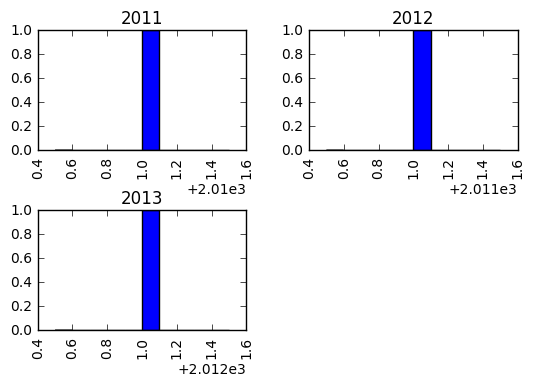

In [157]:
testDF = theDF[theDF[theDF.columns[-2]] == "00601"]
testDF.hist(by=testDF["year"])
#testDF[testDF.year == 2011].hist()

In [121]:
theDF.hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fed1c565d68>]], dtype=object)

## Q3: How much do they contribute to the taxi industry?
#### Let's make this more specific, maybe?

In [3]:
taxi_url="https://data.cityofnewyork.us/resource/2yzn-sicd.json"

In [4]:
taxi_df = pd.read_json(taxi_url)

### What does the data look like?

In [5]:
taxi_df.head()

,dropoff_datetime,dropoff_latitude,dropoff_longitude,extra,fare_amount,mta_tax,passenger_count,payment_type,pickup_datetime,pickup_latitude,pickup_longitude,rate_code,store_and_fwd_flag,tip_amount,tolls_amount,total_amount,trip_distance,vendor_id
0,2015-01-06T19:06:32.000,40.727608,-73.991150,1.0,8.0,0.5,1,2,2015-01-06T18:58:18.000,40.707218,-74.004639,1,N,0.00,0.0,9.80,1.60,1
1,2015-03-10T22:43:36.000,40.759827,-73.972092,0.5,6.5,0.5,1,1,2015-03-10T22:37:24.000,40.770870,-73.962952,1,N,1.55,0.0,9.35,1.00,1
2,2015-04-21T14:36:54.000,40.754753,-73.977829,0.0,8.5,0.5,1,1,2015-04-21T14:25:29.000,40.749969,-73.991432,1,N,2.75,0.0,12.05,1.30,1
3,2015-03-02T18:13:08.000,40.746220,-73.985039,1.0,13.0,0.5,1,2,2015-03-02T17:55:05.000,40.769695,-73.964905,1,N,0.00,0.0,14.80,2.20,1
4,2015-01-26T12:02:13.000,40.735851,-73.993103,0.0,8.5,0.5,4,1,2015-01-26T11:52:13.000,40.733055,-73.975365,1,N,1.86,0.0,11.16,1.42,2


/home/stuff/anaconda3/envs/rentistoodamnhigh/bin/python


In [3]:
#!pip install git+https://github.com/CommerceDataService/census-wrapper.git

  Cloning https://github.com/CommerceDataService/census-wrapper.git to /tmp/pip-nlrvh24j-build
  Running setup.py bdist_wheel for us ... - \ | done
  Stored in directory: /home/stuff/.cache/pip/wheels/1c/18/a6/f0a1651888a6c980d14ce6c68ae0bff4419e20bce4f2473a96
  Running setup.py bdist_wheel for jellyfish ... - \ | / - \ | / - \ | / - \ done
  Stored in directory: /home/stuff/.cache/pip/wheels/a5/d1/70/3ee3c2bed592a55e2be58210ac6d6618ada7df353e3621e42c
Successfully built us jellyfish
  Running setup.py install for census ... - \ | done


In [4]:
!pip install census_area

    100% |████████████████████████████████| 184kB 43kB/s 
    Complete output from command python setup.py egg_info:
    Failed `CDLL(libgeos_c.so.1)`
    Failed `CDLL(libgeos_c.so)`
    Traceback (most recent call last):
      File "<string>", line 1, in <module>
      File "/tmp/pip-build-_b8go_w7/shapely/setup.py", line 38, in <module>
        from shapely._buildcfg import geos_version_string, geos_version, \
      File "/tmp/pip-build-_b8go_w7/shapely/shapely/_buildcfg.py", line 167, in <module>
        fallbacks=['libgeos_c.so.1', 'libgeos_c.so'])
      File "/tmp/pip-build-_b8go_w7/shapely/shapely/_buildcfg.py", line 161, in load_dll
        libname, fallbacks or []))
    OSError: Could not find library geos_c or load any of its variants ['libgeos_c.so.1', 'libgeos_c.so']
    
    ----------------------------------------
Command "python setup.py egg_info" failed with error code 1 in /tmp/pip-build-_b8go_w7/shapely/
